# Stream Classification
---
notebooks adapted from the [streaming-data-analytics](https://github.com/emanueledellavalle/streaming-data-analytics) repo.

---

## `NEWeather` dataset

**Description:** The National Oceanic and Atmospheric Administration (NOAA),
has compiled a database of weather measurements from over 7,000 weather 
stations worldwide. Records date back to the mid-1900s. Daily measurements
include a variety of features (temperature, pressure, wind speed, etc.) as
well as a series of indicators for precipitation and other weather-related
events. The `NEweather` dataset contains data from this database, specifically
from the Offutt Air Force Base in Bellevue, Nebraska ranging for over 50 years
(1949-1999).

**Features:** 8 Daily weather measurements
 
|       Attribute      | Description |
|:--------------------:|:-----------------------------|
| `temp`                   | Temperature
| `dew_pnt`                | Dew Point
| `sea_lvl_press`          | Sea Level Pressure
| `visibility`             | Visibility
| `avg_wind_spd`           | Average Wind Speed
| `max_sustained_wind_spd` | Maximum Sustained Wind Speed
| `max_temp`               | Maximum Temperature
| `min_temp`               | Minimum Temperature


**Class:** `rain` | 0: no rain, 1: rain
 
**Samples:** 18,159


In [1]:
import pandas as pd
from river.stream import iter_pandas
from river.metrics import Accuracy,BalancedAccuracy,CohenKappa,GeometricMean
from river.metrics.base import Metrics
from river.evaluate import progressive_val_score

C:\Users\w-32\AppData\Local\Temp\ipykernel_26732\716418842.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from river import metrics

y_true = [True, False, True, True, True]
y_pred = [True, True, False, True, True]

metric = metrics.Accuracy()
for yt, yp in zip(y_true, y_pred):
    metric.update(yt, yp)

metric

Accuracy: 60.00%

In [3]:
metric.get()

0.6

In [4]:
data = pd.read_csv("../datasets/NEweather.csv")
features = data.columns[:-1]

In [5]:
import matplotlib.pyplot as plt
data["temp"]

0        19.8
1        26.8
2        34.6
3        26.4
4        14.7
         ... 
18154    32.6
18155    36.8
18156    41.9
18157    42.4
18158    36.6
Name: temp, Length: 18159, dtype: float64

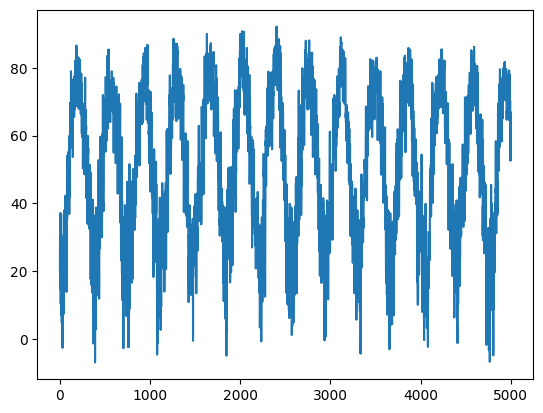

In [6]:
plt.plot(data["temp"][:5000])

In this example, we load the data from a csv file with `pandas.read_csv`, and we use the [iter_pandas](https://riverml.xyz/latest/api/stream/iter-pandas/) utility method to iterate over the `DataFrame`.

In [7]:
stream = iter_pandas(X=data[features], y=data['rain'])

In [8]:
for el in stream:
    print(el)
    break

({'temp': 19.8, 'dew_pnt': 14.0, 'sea_lvl_press': 1019.6, 'visibility': 8.4, 'avg_wind_spd': 9.9, 'max_sustained_wind_spd': 15.9, 'max_temp': 28.9, 'min_temp': 14.0}, 0)


## Naïve Bayes
---
[GaussianNB](https://riverml.xyz/latest/api/naive-bayes/GaussianNB/) maintains a Gaussian distribution $G_{cf}$ is maintained for each class $c$ and each feature $f$. Each Gaussian is updated using the amount associated with each feature; the details can be be found in proba.Gaussian. The joint log-likelihood is then obtained by summing the log probabilities of each feature associated with each class.

In [9]:
from river.naive_bayes import GaussianNB

model = GaussianNB()
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=1000)

[1,000] Accuracy: 71.17%
BalancedAccuracy: 71.80%
GeometricMean: 71.78%
CohenKappa: 39.94%
[2,000] Accuracy: 69.78%
BalancedAccuracy: 70.26%
GeometricMean: 70.25%
CohenKappa: 36.02%
[3,000] Accuracy: 68.99%
BalancedAccuracy: 69.60%
GeometricMean: 69.59%
CohenKappa: 34.19%
[4,000] Accuracy: 68.84%
BalancedAccuracy: 68.86%
GeometricMean: 68.86%
CohenKappa: 33.49%
[5,000] Accuracy: 69.11%
BalancedAccuracy: 67.97%
GeometricMean: 67.91%
CohenKappa: 32.71%
[6,000] Accuracy: 69.18%
BalancedAccuracy: 67.90%
GeometricMean: 67.82%
CohenKappa: 32.72%
[7,000] Accuracy: 69.20%
BalancedAccuracy: 67.91%
GeometricMean: 67.83%
CohenKappa: 32.67%
[8,000] Accuracy: 68.53%
BalancedAccuracy: 67.33%
GeometricMean: 67.26%
CohenKappa: 31.61%
[9,000] Accuracy: 68.67%
BalancedAccuracy: 66.69%
GeometricMean: 66.50%
CohenKappa: 30.99%
[10,000] Accuracy: 69.07%
BalancedAccuracy: 66.37%
GeometricMean: 66.02%
CohenKappa: 30.78%
[11,000] Accuracy: 69.56%
BalancedAccuracy: 66.54%
GeometricMean: 66.12%
CohenKappa: 31.2

Accuracy: 69.24%
BalancedAccuracy: 66.28%
GeometricMean: 65.81%
CohenKappa: 31.31%

## K-Nearest Neighbors
---
[KNN](https://riverml.xyz/latest/api/neighbors/KNNClassifier/) is a non-parametric classification method that keeps track of the last window_size training samples. The predicted class-label for a given query sample is obtained in two steps:

- Find the closest n_neighbors to the query sample in the data window. 
- Aggregate the class-labels of the n_neighbors to define the predicted class for the query sample.

In [10]:
from river.neighbors import KNNClassifier, LazySearch

# KNN with limited window size
model = KNNClassifier(n_neighbors=5, engine=LazySearch(window_size=1000))
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=1000)

[1,000] Accuracy: 77.18%
BalancedAccuracy: 71.52%
GeometricMean: 69.63%
CohenKappa: 45.32%
[2,000] Accuracy: 78.34%
BalancedAccuracy: 71.07%
GeometricMean: 68.71%
CohenKappa: 44.95%
[3,000] Accuracy: 78.86%
BalancedAccuracy: 70.49%
GeometricMean: 67.63%
CohenKappa: 44.34%
[4,000] Accuracy: 78.29%
BalancedAccuracy: 70.44%
GeometricMean: 67.78%
CohenKappa: 43.93%
[5,000] Accuracy: 78.06%
BalancedAccuracy: 70.37%
GeometricMean: 67.77%
CohenKappa: 43.68%
[6,000] Accuracy: 77.95%
BalancedAccuracy: 70.53%
GeometricMean: 68.08%
CohenKappa: 43.80%
[7,000] Accuracy: 78.24%
BalancedAccuracy: 70.95%
GeometricMean: 68.65%
CohenKappa: 44.55%
[8,000] Accuracy: 77.96%
BalancedAccuracy: 70.85%
GeometricMean: 68.60%
CohenKappa: 44.26%
[9,000] Accuracy: 78.12%
BalancedAccuracy: 71.08%
GeometricMean: 68.83%
CohenKappa: 44.81%
[10,000] Accuracy: 78.16%
BalancedAccuracy: 71.12%
GeometricMean: 68.91%
CohenKappa: 44.84%
[11,000] Accuracy: 78.35%
BalancedAccuracy: 71.33%
GeometricMean: 69.19%
CohenKappa: 45.1

Accuracy: 77.91%
BalancedAccuracy: 72.06%
GeometricMean: 70.33%
CohenKappa: 46.24%

In [11]:
from river.neighbors import KNNClassifier

model = KNNClassifier(n_neighbors=5, engine=LazySearch(window_size=50))
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=1000)

[1,000] Accuracy: 75.08%
BalancedAccuracy: 68.85%
GeometricMean: 66.47%
CohenKappa: 39.94%
[2,000] Accuracy: 76.74%
BalancedAccuracy: 68.83%
GeometricMean: 65.93%
CohenKappa: 40.45%
[3,000] Accuracy: 76.59%
BalancedAccuracy: 67.35%
GeometricMean: 63.69%
CohenKappa: 37.86%
[4,000] Accuracy: 76.19%
BalancedAccuracy: 67.52%
GeometricMean: 64.12%
CohenKappa: 37.98%
[5,000] Accuracy: 75.38%
BalancedAccuracy: 66.71%
GeometricMean: 63.20%
CohenKappa: 36.19%
[6,000] Accuracy: 75.03%
BalancedAccuracy: 66.58%
GeometricMean: 63.21%
CohenKappa: 35.74%
[7,000] Accuracy: 75.53%
BalancedAccuracy: 66.99%
GeometricMean: 63.62%
CohenKappa: 36.68%
[8,000] Accuracy: 75.13%
BalancedAccuracy: 66.82%
GeometricMean: 63.52%
CohenKappa: 36.21%
[9,000] Accuracy: 75.01%
BalancedAccuracy: 66.82%
GeometricMean: 63.56%
CohenKappa: 36.20%
[10,000] Accuracy: 75.07%
BalancedAccuracy: 66.75%
GeometricMean: 63.42%
CohenKappa: 36.09%
[11,000] Accuracy: 75.30%
BalancedAccuracy: 66.79%
GeometricMean: 63.41%
CohenKappa: 36.2

Accuracy: 74.43%
BalancedAccuracy: 67.23%
GeometricMean: 64.40%
CohenKappa: 36.73%

## Hoeffding Tree
---

[Hoeffding Tree](https://riverml.xyz/latest/api/tree/HoeffdingTreeClassifier/) 

Tree-based models are popular due to their interpretability. They use a tree data structure to model the data. When a sample arrives, it traverses the tree until it reaches a leaf node. Internal nodes define the path for a data sample based on the values of its features. Leaf nodes are models that provide predictions for unlabeled-samples and can update their internal state using the labels from labeled samples.

In [12]:
from river.tree import HoeffdingTreeClassifier

model = HoeffdingTreeClassifier()
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=1000)

[1,000] Accuracy: 70.87%
BalancedAccuracy: 71.11%
GeometricMean: 71.10%
CohenKappa: 38.92%
[2,000] Accuracy: 69.73%
BalancedAccuracy: 68.12%
GeometricMean: 68.01%
CohenKappa: 33.45%
[3,000] Accuracy: 70.89%
BalancedAccuracy: 63.00%
GeometricMean: 60.16%
CohenKappa: 26.85%
[4,000] Accuracy: 71.29%
BalancedAccuracy: 61.85%
GeometricMean: 57.40%
CohenKappa: 25.57%
[5,000] Accuracy: 71.79%
BalancedAccuracy: 62.23%
GeometricMean: 57.58%
CohenKappa: 26.59%
[6,000] Accuracy: 72.13%
BalancedAccuracy: 62.56%
GeometricMean: 57.88%
CohenKappa: 27.40%
[7,000] Accuracy: 72.82%
BalancedAccuracy: 64.11%
GeometricMean: 60.42%
CohenKappa: 30.23%
[8,000] Accuracy: 72.58%
BalancedAccuracy: 64.31%
GeometricMean: 60.90%
CohenKappa: 30.45%
[9,000] Accuracy: 72.80%
BalancedAccuracy: 63.98%
GeometricMean: 59.98%
CohenKappa: 30.21%
[10,000] Accuracy: 72.85%
BalancedAccuracy: 63.64%
GeometricMean: 59.32%
CohenKappa: 29.69%
[11,000] Accuracy: 73.30%
BalancedAccuracy: 63.81%
GeometricMean: 59.37%
CohenKappa: 30.1

Accuracy: 73.55%
BalancedAccuracy: 65.87%
GeometricMean: 62.56%
CohenKappa: 34.07%

## Hoeffding Adaptive Tree
---
The [HAT](https://riverml.xyz/latest/api/tree/HoeffdingAdaptiveTreeClassifier/) model uses `ADWIN` to detect changes. If change is detected in a given branch, an alternate branch is created and eventually replaces the original branch if it shows better performance on new data.

In [13]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['rain'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metrics, 
                      print_every=1000)

[1,000] Accuracy: 70.67%
BalancedAccuracy: 70.72%
GeometricMean: 70.72%
CohenKappa: 38.32%
[2,000] Accuracy: 69.88%
BalancedAccuracy: 70.05%
GeometricMean: 70.05%
CohenKappa: 35.85%
[3,000] Accuracy: 69.72%
BalancedAccuracy: 67.38%
GeometricMean: 67.15%
CohenKappa: 32.06%
[4,000] Accuracy: 71.39%
BalancedAccuracy: 67.12%
GeometricMean: 66.31%
CohenKappa: 33.24%
[5,000] Accuracy: 71.97%
BalancedAccuracy: 66.39%
GeometricMean: 64.95%
CohenKappa: 32.83%
[6,000] Accuracy: 72.50%
BalancedAccuracy: 66.95%
GeometricMean: 65.52%
CohenKappa: 34.03%
[7,000] Accuracy: 73.17%
BalancedAccuracy: 67.60%
GeometricMean: 66.19%
CohenKappa: 35.37%
[8,000] Accuracy: 72.88%
BalancedAccuracy: 67.33%
GeometricMean: 65.88%
CohenKappa: 34.91%
[9,000] Accuracy: 72.94%
BalancedAccuracy: 66.52%
GeometricMean: 64.51%
CohenKappa: 33.97%
[10,000] Accuracy: 73.05%
BalancedAccuracy: 66.36%
GeometricMean: 64.21%
CohenKappa: 33.78%
[11,000] Accuracy: 73.63%
BalancedAccuracy: 66.66%
GeometricMean: 64.41%
CohenKappa: 34.5

Accuracy: 73.43%
BalancedAccuracy: 67.90%
GeometricMean: 66.25%
CohenKappa: 36.72%

## Concept Drift Impact

Concept drift can negatively impact learning methods if not properly handled. Multiple real-world applications suffer **model degradation** as the models can not adapt to changes in the data.

---
## `AGRAWAL` dataset

We will load the data from a csv file. The data was generated using the `AGRAWAL` data generator with 3 **gradual drifts** at the 5k, 10k, and 15k marks. It contains 9 features, 6 numeric and 3 categorical.

There are 10 functions for generating binary class labels from the features. These functions determine whether a **loan** should be approved.

| Feature    | Description            | Values                                                                |
|------------|------------------------|-----------------------------------------------------------------------|
| `salary`     | salary                 | uniformly distributed from 20k to 150k                                |
| `commission` | commission             | if (salary <   75k) then 0 else uniformly distributed from 10k to 75k |
| `age`        | age                    | uniformly distributed from 20 to 80                                   |
| `elevel`     | education level        | uniformly chosen from 0 to 4                                          |
| `car`        | car maker              | uniformly chosen from 1 to 20                                         |
| `zipcode`    | zip code of the town   | uniformly chosen from 0 to 8                                          |
| `hvalue`     | value of the house     | uniformly distributed from 50k x zipcode to 100k x zipcode            |
| `hyears`     | years house owned      | uniformly distributed from 1 to 30                                    |
| `loan`       | total loan amount      | uniformly distributed from 0 to 500k                                  |

**Class:** `y` | 0: no loan, 1: loan
 
**Samples:** 20,000

`elevel`, `car`, and `zipcode` are categorical features.

In [14]:
data = pd.read_csv("../datasets/agr_a_20k.csv")
features = data.columns[:-1]

In [15]:
data

,salary,commission,age,elevel,car,zipcode,hvalue,hyears,loan,class
0,110499.735409,0.000000,54,3,6,4,135000.0,30,354724.182530,1
1,140893.779095,0.000000,44,4,12,7,135000.0,2,395015.339020,1
2,119159.651677,0.000000,49,2,0,3,135000.0,22,122025.085242,1
3,20000.000000,52593.636537,56,0,19,1,135000.0,30,99629.621457,1
4,93956.320488,0.000000,59,1,6,1,135000.0,1,458679.826238,0
...,...,...,...,...,...,...,...,...,...,...
19995,112152.907316,0.000000,20,2,13,5,135000.0,13,180321.775202,1
19996,150000.000000,0.000000,39,3,5,3,135000.0,24,310994.278571,1
19997,86983.916858,0.000000,70,0,14,4,135000.0,13,88018.865692,1
19998,40050.075996,47604.107868,70,4,9,1,135000.0,25,331893.642348,1


<Axes: >

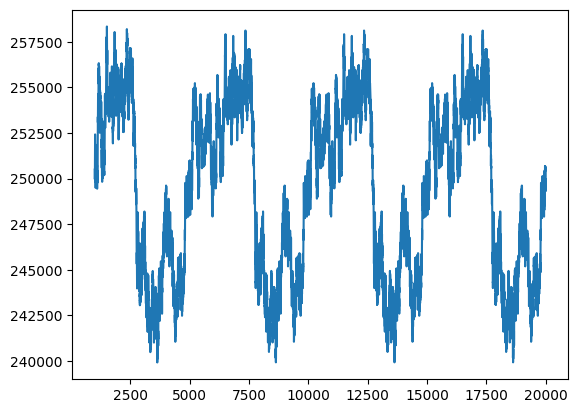

In [16]:
s = data.loan.ewm(alpha=0.002).mean()
s[s.index > 1000].plot()

<Axes: >

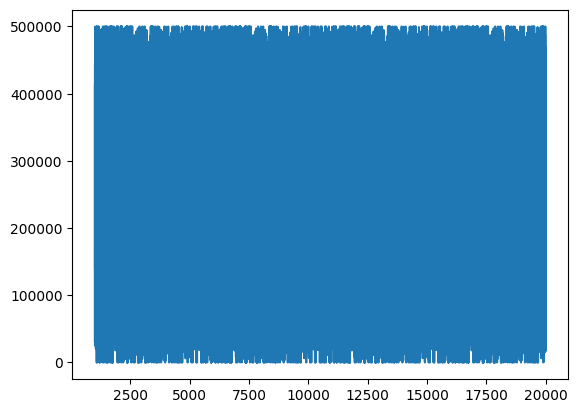

In [17]:
s = data.loan
s[s.index > 1000].plot()

## Naïve Bayes

In [18]:
from river.naive_bayes import GaussianNB

model = GaussianNB()
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=1000)

[1,000] Accuracy: 83.98%
BalancedAccuracy: 77.03%
GeometricMean: 74.15%
CohenKappa: 60.00%
[2,000] Accuracy: 86.29%
BalancedAccuracy: 80.38%
GeometricMean: 78.21%
CohenKappa: 66.57%
[3,000] Accuracy: 87.00%
BalancedAccuracy: 81.06%
GeometricMean: 79.01%
CohenKappa: 68.08%
[4,000] Accuracy: 87.55%
BalancedAccuracy: 81.46%
GeometricMean: 79.46%
CohenKappa: 69.09%
[5,000] Accuracy: 87.42%
BalancedAccuracy: 81.35%
GeometricMean: 79.32%
CohenKappa: 68.86%
[6,000] Accuracy: 80.50%
BalancedAccuracy: 75.06%
GeometricMean: 71.76%
CohenKappa: 54.67%
[7,000] Accuracy: 74.71%
BalancedAccuracy: 70.42%
GeometricMean: 66.14%
CohenKappa: 43.88%
[8,000] Accuracy: 70.87%
BalancedAccuracy: 67.68%
GeometricMean: 62.94%
CohenKappa: 37.38%
[9,000] Accuracy: 68.01%
BalancedAccuracy: 65.87%
GeometricMean: 60.95%
CohenKappa: 32.99%
[10,000] Accuracy: 66.25%
BalancedAccuracy: 64.90%
GeometricMean: 60.26%
CohenKappa: 30.56%
[11,000] Accuracy: 66.75%
BalancedAccuracy: 64.90%
GeometricMean: 60.76%
CohenKappa: 30.8

Accuracy: 65.94%
BalancedAccuracy: 64.90%
GeometricMean: 61.78%
CohenKappa: 30.38%

## Hoeffding Tree

In [19]:
from river.tree import HoeffdingTreeClassifier

model = HoeffdingTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'])
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['class'])

progressive_val_score(dataset=stream,
                      model=model,
                      metric=metrics,
                      print_every=1000)

[1,000] Accuracy: 81.68%
BalancedAccuracy: 74.40%
GeometricMean: 71.12%
CohenKappa: 54.21%
[2,000] Accuracy: 82.29%
BalancedAccuracy: 78.91%
GeometricMean: 78.19%
CohenKappa: 59.46%
[3,000] Accuracy: 83.49%
BalancedAccuracy: 82.29%
GeometricMean: 82.20%
CohenKappa: 63.59%
[4,000] Accuracy: 85.17%
BalancedAccuracy: 84.61%
GeometricMean: 84.60%
CohenKappa: 67.38%
[5,000] Accuracy: 86.20%
BalancedAccuracy: 86.08%
GeometricMean: 86.08%
CohenKappa: 69.88%
[6,000] Accuracy: 81.30%
BalancedAccuracy: 80.57%
GeometricMean: 80.52%
CohenKappa: 60.55%
[7,000] Accuracy: 78.98%
BalancedAccuracy: 78.71%
GeometricMean: 78.70%
CohenKappa: 56.96%
[8,000] Accuracy: 77.95%
BalancedAccuracy: 78.01%
GeometricMean: 78.01%
CohenKappa: 55.54%
[9,000] Accuracy: 78.36%
BalancedAccuracy: 78.45%
GeometricMean: 78.45%
CohenKappa: 56.62%
[10,000] Accuracy: 78.93%
BalancedAccuracy: 78.98%
GeometricMean: 78.98%
CohenKappa: 57.83%
[11,000] Accuracy: 77.41%
BalancedAccuracy: 77.58%
GeometricMean: 77.55%
CohenKappa: 54.8

Accuracy: 72.40%
BalancedAccuracy: 72.63%
GeometricMean: 72.50%
CohenKappa: 44.99%

## Hoeffding Adaptive Tree

In [20]:
from river.tree import HoeffdingAdaptiveTreeClassifier

model = HoeffdingAdaptiveTreeClassifier(nominal_attributes=['elevel', 'car', 'zipcode'], seed=42)
metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X=data[features], y=data['class'])

progressive_val_score(dataset=stream, 
                      model=model, 
                      metric=metrics, 
                      print_every=1000)

[1,000] Accuracy: 82.58%
BalancedAccuracy: 76.35%
GeometricMean: 74.03%
CohenKappa: 57.35%
[2,000] Accuracy: 86.84%
BalancedAccuracy: 84.59%
GeometricMean: 84.30%
CohenKappa: 70.26%
[3,000] Accuracy: 88.36%
BalancedAccuracy: 87.35%
GeometricMean: 87.29%
CohenKappa: 74.13%
[4,000] Accuracy: 89.80%
BalancedAccuracy: 89.28%
GeometricMean: 89.26%
CohenKappa: 77.31%
[5,000] Accuracy: 90.30%
BalancedAccuracy: 90.15%
GeometricMean: 90.15%
CohenKappa: 78.60%
[6,000] Accuracy: 83.51%
BalancedAccuracy: 82.16%
GeometricMean: 81.97%
CohenKappa: 64.68%
[7,000] Accuracy: 79.11%
BalancedAccuracy: 77.89%
GeometricMean: 77.58%
CohenKappa: 56.39%
[8,000] Accuracy: 77.58%
BalancedAccuracy: 76.54%
GeometricMean: 76.11%
CohenKappa: 53.81%
[9,000] Accuracy: 77.03%
BalancedAccuracy: 76.29%
GeometricMean: 75.79%
CohenKappa: 53.18%
[10,000] Accuracy: 77.59%
BalancedAccuracy: 77.16%
GeometricMean: 76.79%
CohenKappa: 54.71%
[11,000] Accuracy: 77.35%
BalancedAccuracy: 76.82%
GeometricMean: 76.54%
CohenKappa: 54.0

Accuracy: 79.81%
BalancedAccuracy: 79.55%
GeometricMean: 79.38%
CohenKappa: 59.35%

# Questions
- **Experimental Comparison**: compare the performance of adaptive and non-adaptive models on the Agrawal dataset.
- **Adapt an offline method**: train an offline method (anything from sklearn) using a drift detector (e.g. ADWIN). Whenever ADWIN finds a drift, retrain the model from scratch.
- **synthetic stream generators**: river provides many streams (`river.datasets`) and synthetic stream generators (`river.datasets.synth`). Evaluate a couple of models on a nonstationary stream. Then, try to use ADWIN to detect drifts and plot the DRIFT alarm and evaluate the alarm latency.
- **Ensembling**: try one of the ensemble methods from `river.ensemble`Is it adaptive to concept drift? Does it behave as you expected from the theory?